In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import curve_fit
import datetime

$$H_R = \frac{i\eta\Omega}{2}\left(\sigma_+a+\sigma_-a^\dagger\right)$$
$$H_B = \frac{i\eta\Omega}{2}\left(\sigma_-a+\sigma_+a^\dagger\right)$$

$$\left|0\right>\otimes\left|\overline{n}\right>$$

$$\frac{P_{R, e}(t)}{P_{B, e}(t)-P_{R, e}(t)}$$

$$\overline{n}\approx 5$$

## Read the file

In [2]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion1, ion1_raw, ion1_bottom, ion1_top, ion2, ion2_raw, \
    ion2_bottom, ion2_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, 
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion1

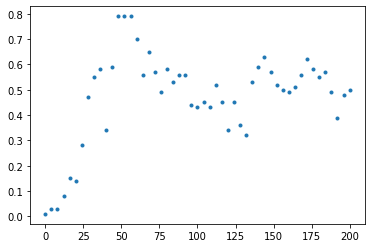

In [3]:
xb, BSB = readFile('ms_blue_time_scan_rfsoc_006')
plt.plot(xb, BSB, '.')

## Define Hamiltonian

In [4]:
times = xb
nMax = 20

In [5]:
def H(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.thermal_dm(nMax, n))

    c_ops = [
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result.expect[0]

(0, 1)

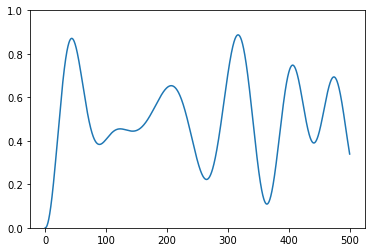

In [6]:
def H2(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.ket2dm(qt.coherent(nMax, n)))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.ket2dm(qt.coherent(nMax, n)))

    c_ops = [
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result

H0 = []
n0 = 1
etaOmega = 0.05
count = 0
times = np.linspace(0,500,2001)
results = H2(n0, False, 0, etaOmega, times)# Test Blue sideband
    
plt.plot(times,results.expect[0])
plt.ylim([0,1])

### Test the Hamiltonian

(0, 1)

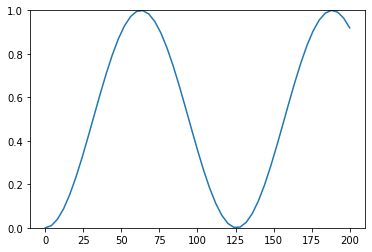

In [7]:
H0 = []
n0 = 0
etaOmega = 0.05
count = 0
for t in xb:
    H0.append(H(n0, False, 0, etaOmega, [0,t])[-1]) # Test Blue sideband
    
plt.plot(xb,H0)
plt.ylim([0,1])

## Curve fit

In [8]:
def Red(x, n0, etaOmega):
    return H(n0, True, 0, etaOmega, x)
def Blue(x, n0, etaOmega):
    return H(n0, False, 0, etaOmega, x)

def FitRed(xdata, ydata, guess):
    popt, pcov = curve_fit(Red, xdata, ydata, guess, sigma=np.sqrt(ydata*(1-ydata)/100)+0.005)
    plt.plot(xdata, Red(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.errorbar(xdata, ydata, yerr=np.sqrt(ydata*(1-ydata)/100)+0.005 ,ls='',marker='o')
    plt.legend()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])
    
def FitBlue(xdata, ydata, guess):
    popt, pcov = curve_fit(Blue, xdata, ydata, guess, sigma=np.sqrt(ydata*(1-ydata)/100)+0.005, absolute_sigma = False)
    plt.plot(xdata, Blue(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.errorbar(xdata, ydata, yerr=np.sqrt(ydata*(1-ydata)/100)+0.005 ,ls='',marker='o')
    plt.legend()
    plt.show()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])

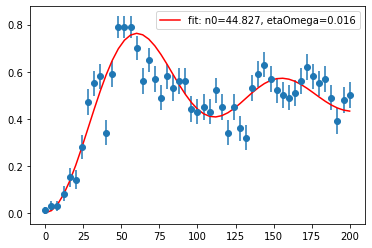

[4.48265256e+01 1.58163565e-02]
34.668267520987094


In [9]:
### Test fit: BSB
xdata = xb
ydata = BSB
guess = np.array([0.4, 0.05])
BSB_fit = FitBlue(xdata, ydata, guess)

The loop fitting doesn't work well because it's highly sensitive to the initial guess (expecially the `etaOmega` parameter). If needed we have to change the guess value mannually.

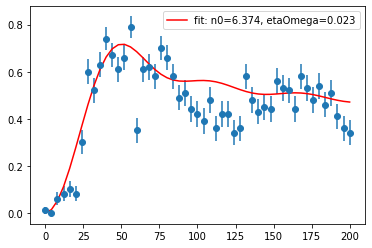

[6.37422896 0.023318  ]
2.229060226275429


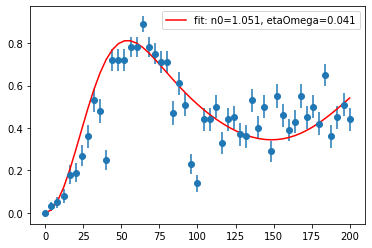

[1.05079776 0.04143122]
0.2327030182776634


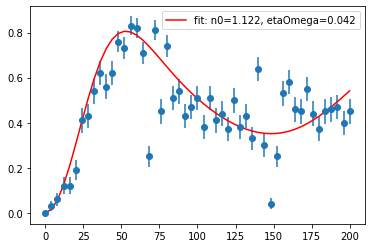

[1.1219188  0.04153808]
0.260077456968058


/Users/sunke/opt/anaconda3/lib/python3.7/site-packages/qutip/states.py:416: RuntimeWarning: invalid value encountered in log
  beta = np.log(1.0 / n + 1.0)
/Users/sunke/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1014: UserWarning: zvode: Illegal input detected. (See printed message.)
  self.messages.get(istate, unexpected_istate_msg)))


Exception: ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.

In [11]:
ls = [5,7,8,9,10,11,12]
ns = []
errs = []
for l in ls:
    filename = 'ms_blue_time_scan_rfsoc_'+str(int(l)).zfill(3)
    xb, BSB = readFile(filename)
    guess = np.array([0.1, 0.05])
    BSB_fit, nerr= FitBlue(xb, BSB, guess)
    ns.append(BSB_fit[0])
    errs.append(nerr)

In [25]:
ls_blue = [5,7,8,9,10,11,12]
ls_red = [6,8,9,10,11,12,13]
ns = []
for i in range(len(ls_blue)):
    filename = 'ms_blue_time_scan_rfsoc_'+str(int(ls_blue[i])).zfill(3)
    xb, BSB = readFile(filename)
    filename = 'ms_red_time_scan_rfsoc_'+str(int(ls_red[i])).zfill(3)
    xr, RSB = readFile(filename)
    pop_blue = sum(BSB)/len(BSB)
    pop_red = sum(RSB)/len(RSB)
    ns.append(pop_red/(pop_blue-pop_red))
wait_time = np.array([0, 0.0001, 0.0005, 0.01, 0.050, 0.200, 0.500]) # Unit: s

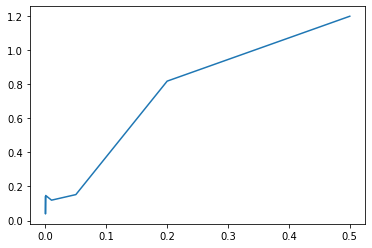

In [26]:
plt.plot(wait_time, ns)

## Define heating rate fit

In [41]:
def Heating(x, a, b):
    return a * x + b
def heatingFit(xdata, ydata, yerr):
#     popt, pcov = curve_fit(Heating, xdata, ydata, sigma=yerr, absolute_sigma= False)
    popt, pcov = curve_fit(Heating, xdata, ydata, absolute_sigma= False)
    print(r'Heating rate = '+str(popt[0])+r'$\pm$'+str(np.sqrt(np.diag(pcov)[0]))+r' quanta/s ')
    print('Intersept = '+str(popt[1])+r'$\pm$'+str(np.sqrt(np.diag(pcov)[1]))+' quanta')
    fitY = [Heating(x, popt[0], popt[1]) for x in xdata]
    'fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt)
    plt.plot(xdata, Heating(xdata,*popt), 'grey')
    plt.errorbar(xdata, ydata, yerr,ls='',marker='o',mec='firebrick',ecolor='firebrick',mfc='pink')
#     plt.text(0,2.8, r'Heating rate = '+str(round(popt[0],3))+r' $\pm$ '+str(round(np.sqrt(np.diag(pcov)[0]),3))+r' q/s')
    plt.xlabel('Time (s)')
    plt.ylabel('Motional quanta')
    plt.title('Heating rate = %5.2f' % popt[0]+r' quanta/s ')
    plt.show()

Heating rate = 2.3204850371279$\pm$0.2696622315941024 quanta/s 
Intersept = 0.1205336758325618$\pm$0.055132597551905124 quanta


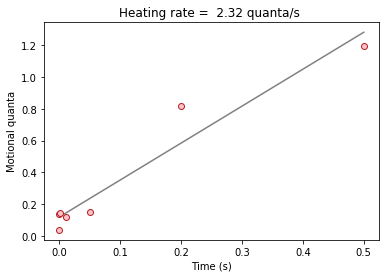

In [42]:
errs = [0 for i in range(len(wait_time))]
pp = heatingFit(wait_time, ns, errs)